# Import Libraries

In [1]:
# Data Collection
import googlemaps
import requests

# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Sentiment Analysis (XLM-RoBERTa Core)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import sentencepiece  # typically used internally by tokenizers; explicit import may not be needed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback  # Critical for early stopping
)
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.tensorboard import SummaryWriter

# Visualization & Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pydantic import BaseModel
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import openpyxl
import re
import html
import string
import os
import optuna
import gc
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

c:\Users\dewam\anaconda3\envs\xlm_roberta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Cleaning

In [ ]:
# Configuration
FILE_PATH = "dataset/kertagosa.xlsx"

def process_data():
    print("--- Processing Data ---")
    
    # Load
    if not os.path.exists(FILE_PATH):
        print(f"❌ File not found: {FILE_PATH}")
        return
    
    df = pd.read_excel(FILE_PATH)
    print(f"Original rows: {len(df)}")
    
    # Ensure 'text' exists
    if 'text' not in df.columns:
        print("❌ 'text' column missing!")
        return
        
    df = df.dropna(subset=['text'])
    df = df[df['text'].astype(str).str.strip() != ""]
    print(f"Rows after cleaning: {len(df)}")
    
    # Check for 'rating' or 'stars' column
    rating_col = None
    if 'rating' in df.columns:
        rating_col = 'rating'
    elif 'star' in df.columns:
        rating_col = 'star'
    elif 'stars' in df.columns:
        rating_col = 'stars'
        
    if not rating_col:
        print("❌ Rating column not found (checked 'rating', 'star', 'stars')")
        return

    print(f"Using rating column: '{rating_col}'")

    # Function to map rating to sentiment
    def get_sentiment(score):
        try:
            s = float(score)
            if s <= 2:
                return "Negative"
            elif s == 3:
                return "Neutral"
            elif s >= 4:
                return "Positive"
        except:
            return "Neutral" # Fallback

    # Function to encode label (0, 1, 2)
    def encode_label(sentiment):
        if sentiment == "Negative":
            return 0
        elif sentiment == "Neutral":
            return 1
        elif sentiment == "Positive":
            return 2
        return 1

    # Apply Map
    df['sentiment'] = df[rating_col].apply(get_sentiment)
    df['label'] = df['sentiment'].apply(encode_label)
    
    # Show Distribution
    print("\nLabel Distribution:")
    print(df['sentiment'].value_counts())
    
    # 4. Save (Overwrite)
    df.to_excel(FILE_PATH, index=False)
    print(f"\n✅ Saved updated data to: {FILE_PATH}")
 
process_data()

--- Processing Data ---
Original rows: 1562
Rows after cleaning: 1562
Using rating column: 'star'

Label Distribution:
sentiment
Positive    1439
Neutral       91
Negative      32
Name: count, dtype: int64

✅ Saved updated data to: dataset/kertagosa.xlsx


In [9]:
# Configuration
FILE_PATH = "dataset/tripadvisor_reviews.xlsx"
def remove_duplicates():
    print("--- 🧹 Removing Duplicates ---")
    
    # Load Data
    if not os.path.exists(FILE_PATH):
        print(f"❌ File not found: {FILE_PATH}")
        return
    try:
        df = pd.read_excel(FILE_PATH)
        initial_rows = len(df)
        print(f"📄 Full Data: {initial_rows} rows")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return
    # Check Column
    if 'author' not in df.columns:
        print("❌ Error: 'author' column not found.")
        print(f"   Available columns: {list(df.columns)}")
        return
    # Drop Duplicates
    # keep='first' keeps the first occurrence and removes subsequent duplicates
    df_clean = df.drop_duplicates(subset=['author'], keep='first')
    
    final_rows = len(df_clean)
    removed_count = initial_rows - final_rows
    
    print(f"🗑️  Removed {removed_count} duplicate rows.")
    print(f"✅ Unique rows: {final_rows}")
    # Save (Overwrite)
    try:
        df_clean.to_excel(FILE_PATH, index=False)
        print(f"💾 Overwrote file: {FILE_PATH}")
    except Exception as e:
        print(f"❌ Error saving file: {e}")

remove_duplicates()

--- 🧹 Removing Duplicates ---
📄 Full Data: 100 rows
🗑️  Removed 94 duplicate rows.
✅ Unique rows: 6
💾 Overwrote file: dataset/tripadvisor_reviews.xlsx


In [26]:
# Load the dataset
df = pd.read_excel('dataset/tripadvisor2.xlsx')

# Clean sentiment column: lowercase and remove leading/trailing spaces to ensure mapping works
df['sentiment'] = df['sentiment'].astype(str).str.lower().str.strip()

# Define sentiment-to-label mapping
sentiment_mapping = {
    'positive': 2,
    'neutral': 1,
    'netral': 1,      # Indonesian spelling
    'negatif': 0,     # Indonesian spelling
    'negative': 0
}

# Map sentiment to label
df['label'] = df['sentiment'].map(sentiment_mapping)

# Check if mapping resulted in any non-null values before dropping
if df['label'].isnull().all():
    print("⚠️ Warning: No sentiment values matched the mapping. Check your 'sentiment' column values.")
else:
    # Remove rows with unmapped sentiment
    df = df.dropna(subset=['label'])

    # Convert to standard integer
    df['label'] = df['label'].astype(int)

    # Save to Excel
    df.to_excel('dataset/tripadvisor2.xlsx', index=False)
    print(f"✅ Successfully saved {len(df)} rows to 'dataset/tripadvisor2.xlsx'.")

✅ Successfully saved 53 rows to 'dataset/tripadvisor2.xlsx'.


### Final Dataset

In [ ]:
data_dir = "dataset"
file_names = ["kertagosa.xlsx", "tripadvisor_reviews.xlsx", "tripadvisor2.xlsx"]
file_paths = [os.path.join(data_dir, f) for f in file_names]

target_columns = ['language', 'text', 'sentiment', 'label']
all_dfs = []

for path in file_paths:
    df = pd.read_excel(path)
    all_dfs.append(df[target_columns])

dataset = pd.concat(all_dfs, ignore_index=True)
dataset.to_excel("dataset/dataset.xlsx", index=False)

# Exploratory Data Analysis

In [2]:
# Load the dataset
df = pd.read_excel('dataset/dataset.xlsx')

# Analyze the unique languages present in the 'language' column
print(df['language'].unique())


['en' 'id' 'es' 'de' 'fr' 'it' 'ja' 'pl' 'nl' 'da' 'ru' 'zh-Hant' 'ro'
 'jv' 'ms' 'su' 'ko' 'fa' 'iw' 'gu' 'fi' 'lb' 'lt' 'hu' 'sq' 'ig' 'sv'
 'ca' 'mg' 'cs' 'cy' 'so' 'mt' 'haw' 'tr' 'th' 'gl']


In [3]:
# Your language mapping dictionary
language = {
    'en': 'Inggris',
    'id': 'Indonesia',
    'es': 'Spanyol',
    'de': 'Jerman',
    'fr': 'Prancis',
    'it': 'Italia',
    'ja': 'Jepang',
    'pl': 'Polandia',
    'nl': 'Belanda',
    'da': 'Denmark',
    'ru': 'Rusia',
    'zh-Hant': 'Tionghoa Tradisional',
    'ro': 'Rumania',
    'jv': 'Jawa',
    'ms': 'Melayu',
    'su': 'Sunda',
    'ko': 'Korea',
    'fa': 'Persia',
    'iw': 'Ibrani',
    'gu': 'Gujarati',
    'fi': 'Finlandia',
    'lb': 'Luksemburg',
    'lt': 'Lituania',
    'hu': 'Hungaria',
    'sq': 'Albania',
    'ig': 'Igbo',
    'sv': 'Swedia',
    'ca': 'Catalan',
    'mg': 'Malagasi',
    'cs': 'Ceko',
    'cy': 'Wales',
    'so': 'Somalia',
    'mt': 'Malta',
    'haw': 'Hawai',
    'tr': 'Turki',
    'th': 'Thailand',
    'gl': 'Galisia'
}

# Load dataset
file_path = 'dataset/dataset.xlsx'
df = pd.read_excel(file_path)

# Ensure 'language' column exists
if 'language' not in df.columns:
    raise ValueError("❌ Column 'language' not found in the dataset.")

# Map to create 'bahasa' column
df['bahasa'] = df['language'].map(language)

# Optional: Check for unmapped language codes
unmapped = df[df['bahasa'].isna()]['language'].dropna().unique()
if len(unmapped) > 0:
    print("⚠️ Warning: Found unmapped language codes:", unmapped)

# Save back to the same file (or use a different name to keep original)
df.to_excel(file_path, index=False)

print("✅ Column 'bahasa' added and saved successfully.")

✅ Column 'bahasa' added and saved successfully.


In [4]:
# Check basic info and data types
print(df.info())

# Summary statistics for all columns
display(df.describe(include='all'))

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   language   1621 non-null   object
 1   text       1621 non-null   object
 2   sentiment  1621 non-null   object
 3   label      1621 non-null   int64 
 4   bahasa     1621 non-null   object
dtypes: int64(1), object(4)
memory usage: 63.4+ KB
None


,language,text,sentiment,label,bahasa
count,1621,1621,1621,1621.000000,1621
unique,37,1507,6,NaN,37
top,id,Bagus,Positive,NaN,Indonesia
freq,879,22,1445,NaN,879
mean,NaN,NaN,NaN,1.895126,NaN
std,NaN,NaN,NaN,0.370328,NaN
min,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN
50%,NaN,NaN,NaN,2.000000,NaN
75%,NaN,NaN,NaN,2.000000,NaN


Missing values per column:
 language     0
text         0
sentiment    0
label        0
bahasa       0
dtype: int64
Number of duplicate rows: 106


Counts for each language:
bahasa
Indonesia               879
Inggris                 433
Prancis                  70
Jerman                   43
Spanyol                  33
Jawa                     30
Melayu                   23
Italia                   16
Belanda                  16
Polandia                 13
Jepang                   10
Rusia                     8
Sunda                     5
Denmark                   4
Rumania                   4
Hungaria                  3
Lituania                  3
Persia                    2
Gujarati                  2
Tionghoa Tradisional      2
Korea                     2
Malta                     2
Finlandia                 2
Luksemburg                2
Swedia                    2
Ibrani                    1
Albania                   1
Catalan                   1
Igbo                      1
Malagasi                  1
Ceko                      1
Wales                     1
Somalia                   1
Hawai                     1
Turki          

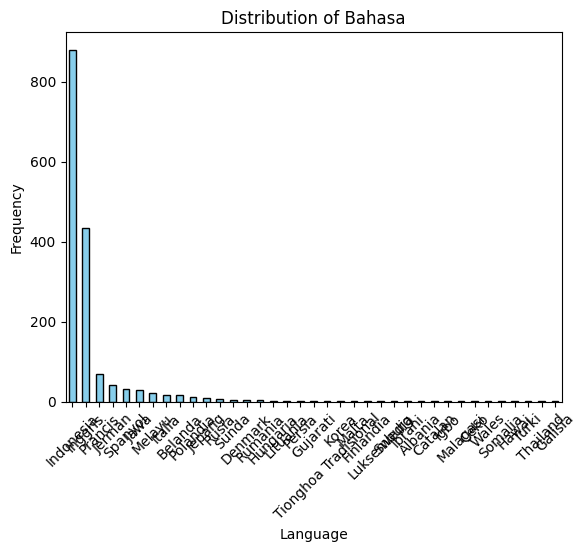

In [5]:
# Count the occurrences in the 'bahasa' column
bahasa_counts = df['bahasa'].value_counts()

# Print the counts
print("Counts for each language:")
print(bahasa_counts)

# Generate the bar chart
bahasa_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Bahasa')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Sentiment Counts:
sentiment
Positive    1445
Neutral       91
positive      41
Negative      32
netral         9
negative       3
Name: count, dtype: int64


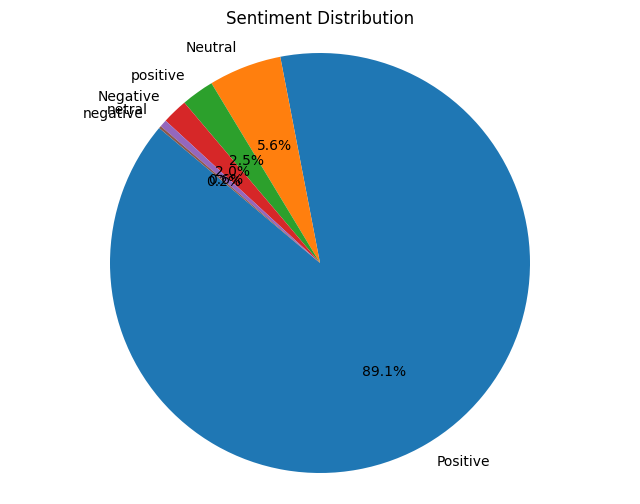

In [6]:
# Count the occurrences of each sentiment class
sentiment_counts = df['sentiment'].value_counts()

# Print the number of occurrences for each class
print("Sentiment Counts:")
print(sentiment_counts)

# Generate the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

In [7]:
df['review_length'] = df['text'].apply(lambda x: len(str(x).split()))
average_word_count = df['review_length'].mean()
print(f"Rata-rata panjang kata per ulasan: {average_word_count:.2f} kata")

Rata-rata panjang kata per ulasan: 12.91 kata


# Data Preprocessing

In [8]:
# Count occurrences per language
bahasa_counts = df['bahasa'].value_counts()
print("Counts for each language:")
print(bahasa_counts)

# Identify languages with at least 10 occurrences
languages_to_keep = bahasa_counts[bahasa_counts >= 10].index

# Filter the DataFrame
df_clean = df[df['bahasa'].isin(languages_to_keep)].reset_index(drop=True)

# Optional: Show remaining counts
print("\nRemaining languages (≥10 occurrences):")
print(df_clean['bahasa'].value_counts())

# Save to new file
df_clean.to_excel('dataset/dataset_clean.xlsx', index=False)

print("\n✅ Cleaned dataset saved to 'dataset_clean.xlsx'")

Counts for each language:
bahasa
Indonesia               879
Inggris                 433
Prancis                  70
Jerman                   43
Spanyol                  33
Jawa                     30
Melayu                   23
Italia                   16
Belanda                  16
Polandia                 13
Jepang                   10
Rusia                     8
Sunda                     5
Denmark                   4
Rumania                   4
Hungaria                  3
Lituania                  3
Persia                    2
Gujarati                  2
Tionghoa Tradisional      2
Korea                     2
Malta                     2
Finlandia                 2
Luksemburg                2
Swedia                    2
Ibrani                    1
Albania                   1
Catalan                   1
Igbo                      1
Malagasi                  1
Ceko                      1
Wales                     1
Somalia                   1
Hawai                     1
Turki          

In [9]:
# Remove duplicate rows based on the 'text' column
df_clean = df.drop_duplicates(subset=['text'], keep='first')
print(f"Removed duplicates. Remaining rows: {len(df_clean)}")

Removed duplicates. Remaining rows: 1507


In [ ]:
# Load deduplicated dataset
df = pd.read_excel('dataset_clean.xlsx')
print(f"📥 Loaded {len(df)} clean rows")

# Clean text (HTML, invisible chars, spacing)
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[\u200b-\u200d\ufeff\u00ad\u2028\u2029]', '', text)  # Invisible chars
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

# Apply relaxed filter
df_clean = df[df['text'].apply(is_meaningful_review)].reset_index(drop=True)
print(f"✅ After relaxed filtering: {len(df_clean)} rows")
df_clean.to_excel('dataset/dataset_clean.xlsx', index=False)

📥 Original dataset loaded: 1566 rows
🧹 After deduplication: 1452 rows
✨ Final cleaned dataset: 24 rows
✅ Saved:
  - 'dataset/dataset_ready.xlsx' (after deduplication)
  - 'dataset/dataset_clean.xlsx' (fully cleaned)


In [ ]:
def add_punct_spaces(text):
    if not isinstance(text, str):
        return text
    # Add space around punctuation (.,!?;: etc.)
    text = re.sub(r'([.,!?;:()"\[\]{}])', r' \1 ', text)
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load the deduplicated dataset
df = pd.read_excel('dataset/dataset_v2.xlsx')

# Apply punctuation spacing to the 'text' column
df['text'] = df['text'].apply(add_punct_spaces)

# Save as a new file
df.to_excel('dataset/dataset_v2.xlsx', index=False)

print("✅ Punctuation spacing applied and saved.")

✅ Punctuation spacing applied and saved.


In [ ]:
from collections import Counter

# -----------------------------
# Load main dataset
# -----------------------------
df = pd.read_excel('dataset/dataset_v2.xlsx')
print(f"📥 Loaded dataset: {len(df)} rows")

# -----------------------------
# Load slang dictionaries
# -----------------------------
def load_slang_map(csv_path):
    try:
        slang_df = pd.read_csv(csv_path)
        if 'slang' not in slang_df.columns or 'formal' not in slang_df.columns:
            raise ValueError(f"Missing 'slang' or 'formal' column in {csv_path}")
        return dict(zip(slang_df['slang'].astype(str).str.lower(), slang_df['formal'].astype(str)))
    except FileNotFoundError:
        print(f"⚠️  Warning: {csv_path} not found. Skipping.")
        return {}
    except Exception as e:
        print(f"❌ Error loading {csv_path}: {e}")
        return {}

indonesian_slang = load_slang_map('slang.csv')
english_slang = load_slang_map('slangenglish.csv')
slang_map = {**indonesian_slang, **english_slang}
print(f"📚 Loaded {len(slang_map)} slang → formal mappings")

# Global counter to track replaced slang
slang_counter = Counter()

def replace_slang(text):
    if not isinstance(text, str):
        return text

    def replacer(match):
        word = match.group(0)
        word_lower = word.lower()
        formal = slang_map.get(word_lower)
        if formal:
            # Track usage
            slang_counter[word_lower] += 1
            # Preserve case
            if word.isupper():
                return formal.upper()
            elif word[0].isupper():
                return formal.capitalize()
            else:
                return formal
        return word

    # Match whole words (handles contractions like "don't")
    return re.sub(r"\b\w+['’]?\w*\b", replacer, text)

# Apply slang replacement
df['text'] = df['text'].apply(replace_slang)

# -----------------------------
# Report most common slang
# -----------------------------
if slang_counter:
    print("\n🔤 Most frequently replaced slang words:")
    for slang, count in slang_counter.most_common(10):
        print(f"  '{slang}' → {count} times")
else:
    print("\n🔤 No slang words were replaced.")

# -----------------------------
# Save final dataset
# -----------------------------
df.to_excel('dataset/dataset_final.xlsx', index=False)
print("\n✅ Slang replacement completed. Saved to 'dataset/dataset_final.xlsx'")

📥 Loaded dataset: 1452 rows
❌ Error loading slangenglish.csv: Error tokenizing data. C error: Expected 2 fields in line 4454, saw 3

📚 Loaded 1480 slang → formal mappings

🔤 Most frequently replaced slang words:
  'the' → 383 times
  'and' → 175 times
  'to' → 167 times
  'yg' → 147 times
  'in' → 141 times
  'is' → 109 times
  'nice' → 79 times
  'you' → 61 times
  'for' → 46 times
  'with' → 46 times

✅ Slang replacement completed. Saved to 'dataset/dataset_final.xlsx'


In [14]:
# Load dataset to LOwercase
df = pd.read_excel('dataset/dataset_final.xlsx')

# Lowercase text
df['text'] = df['text'].str.lower()

# Save
df.to_excel('dataset/dataset_final.xlsx', index=False)
print("✅ Text lowercased and saved.")

✅ Text lowercased and saved.


# Data Split

In [ ]:
from sklearn.model_selection import train_test_split

# Load the final dataset
df = pd.read_excel('dataset/dataset_final.xlsx')

# Ensure the 'label' column exists
if 'label' not in df.columns:
    raise ValueError("❌ The dataset must contain a 'label' column for stratified splitting.")

# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,          # 30% for val + test
    stratify=df['label'],   # preserve label distribution
    random_state=42
)

# Split temp into validation (20% of total) and test (10% of total)
val_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,          # 1/3 of 30% = 10% of total
    stratify=temp_df['label'],
    random_state=42
)

# Print sizes
print(f"📊 Dataset split:")
print(f"   Train:    {len(train_df)} samples ({len(train_df)/len(df):.1%})")
print(f"   Val:      {len(val_df)} samples ({len(val_df)/len(df):.1%})")
print(f"   Test:     {len(test_df)} samples ({len(test_df)/len(df):.1%})")

# Save each split
train_df.to_excel('data_split/dataset_train.xlsx', index=False)
val_df.to_excel('data_split/dataset_val.xlsx', index=False)
test_df.to_excel('data_split/dataset_test.xlsx', index=False)

print("✅ Saved:")
print("   - data_split/dataset_train.xlsx")
print("   - data_split/dataset_val.xlsx")
print("   - data_split/dataset_test.xlsx")

📊 Dataset split:
   Train:    1016 samples (70.0%)
   Val:      290 samples (20.0%)
   Test:     146 samples (10.1%)
✅ Saved:
   - dataset_train.xlsx
   - dataset_val.xlsx
   - dataset_test.xlsx


# Tokenization & Classification

In [ ]:
# Load data
train_df = pd.read_excel('data_split/dataset_train.xlsx')
val_df = pd.read_excel('data_split/dataset_val.xlsx')

# Clean labels (numeric: 0,1,2)
valid_labels = [0, 1, 2]
train_df = train_df[train_df['label'].isin(valid_labels)].reset_index(drop=True)
val_df = val_df[val_df['label'].isin(valid_labels)].reset_index(drop=True)
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# Clean text
train_df = train_df.dropna(subset=['text']).reset_index(drop=True)
val_df = val_df.dropna(subset=['text']).reset_index(drop=True)
train_df = train_df[train_df['text'].str.strip() != ''].reset_index(drop=True)
val_df = val_df[val_df['text'].str.strip() != ''].reset_index(drop=True)

print(f"✅ Cleaned data - Train: {len(train_df)}, Val: {len(val_df)}")

# Tokenizer & model
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
label_list = ["Negative", "Neutral", "Positive"]
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={i: label for i, label in enumerate(label_list)},
    label2id={label: i for i, label in enumerate(label_list)}
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"✅ Model loaded on {device}")

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(t) if pd.notna(t) else "" for t in texts]
        self.labels = [int(l) for l in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx] or "empty review"
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SentimentDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
val_dataset = SentimentDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer)

# Metrics
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training args with TensorBoard and Early Stopping
training_args = TrainingArguments(
    output_dir='./xlm-roberta-sentiment',
    num_train_epochs=10,  # Increased max epochs - early stopping will handle actual stopping
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,  # Keep last 3 models
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    report_to="tensorboard",
    log_level="info",
)

# Initialize Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,  # Stop after 3 epochs with no improvement
            early_stopping_threshold=0.001  # Require at least 0.1% improvement
        )
    ]
)

print("🚀 Starting training with TensorBoard logging and Early Stopping...")
print(f"   • Will stop if validation F1 doesn't improve for 3 epochs")
print(f"   • Minimum improvement required: 0.1%")
trainer.train()

# Save final model
os.makedirs('./xlm-roberta-sentiment-final', exist_ok=True)
trainer.save_model('./xlm-roberta-sentiment-final')
tokenizer.save_pretrained('./xlm-roberta-sentiment-final')

# Save training history
history_df = pd.DataFrame(trainer.state.log_history)
history_df.to_excel('./xlm-roberta-sentiment/training_history.xlsx', index=False)

print("\n✅ Training complete with Early Stopping!")
print(f"   • Best model saved to './xlm-roberta-sentiment-final'")
print(f"   • Training history saved to './xlm-roberta-sentiment/training_history.xlsx'")
print(f"   • Best validation F1: {trainer.state.best_metric:.4f}")
print(f"   • Stopped at epoch: {trainer.state.epoch}")

✅ Cleaned data - Train: 1016, Val: 290


In [ ]:
# Re-load model and data
model = XLMRobertaForSequenceClassification.from_pretrained('./xlm-roberta-sentiment-final')
tokenizer = XLMRobertaTokenizer.from_pretrained('./xlm-roberta-sentiment-final')

train_df = pd.read_excel('data_split/dataset_train.xlsx')
val_df = pd.read_excel('data_split/dataset_val.xlsx')

# Re-apply same cleaning
valid_labels = [0,1,2]
train_df = train_df[train_df['label'].isin(valid_labels)].reset_index(drop=True)
val_df = val_df[val_df['label'].isin(valid_labels)].reset_index(drop=True)
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

trainer = Trainer(model=model, tokenizer=tokenizer)

# Get predictions
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)

# Compute metrics
def get_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return acc, precision, recall, f1

train_acc, train_prec, train_rec, train_f1 = get_metrics(train_preds.predictions, train_preds.label_ids)
val_acc, val_prec, val_rec, val_f1 = get_metrics(val_preds.predictions, val_preds.label_ids)

# Extract losses from training history
train_loss = trainer.state.log_history[-2]['loss']  # Last training loss
val_loss = trainer.state.log_history[-1]['eval_loss']  # Last eval loss

# Create results DataFrame
results = pd.DataFrame([{
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'precision': val_prec,
    'recall': val_rec,
    'f1_score': val_f1
}])

# Save
import os
os.makedirs('result', exist_ok=True)
results.to_excel('result/result.xlsx', index=False)
print("✅ Metrics saved to 'result/result.xlsx'")

# Evaluation

In [ ]:
# HYPERPARAMETER TUNING (AFTER INITIAL EVALUATION)
print("\n" + "="*50)
print("🔍 STARTING HYPERPARAMETER TUNING (3 KEY PARAMETERS)")
print("="*50)

# Prepare datasets (reusing your cleaned data)
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()
val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

# Compute class weights ONCE for all trials (critical for imbalance)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Import EarlyStoppingCallback
from transformers import EarlyStoppingCallback

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    # Calculate all metrics at once to ensure consistency
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc, 
        'f1': f1, 
        'precision': precision, 
        'recall': recall
    }

# Objective function for Optuna
def objective(trial):
    # Sample parameters
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 0.1, log=True)
    
    # Create fresh model
    model = XLMRobertaForSequenceClassification.from_pretrained(
        "FacebookAI/xlm-roberta-base",
        num_labels=3,
        id2label={i: label for i, label in enumerate(["Negative", "Neutral", "Positive"])},
        label2id={label: i for i, label in enumerate(["Negative", "Neutral", "Positive"])}
    ).to(device)
    
    model.class_weights = class_weights
    
    # Training arguments with early stopping
    training_args = TrainingArguments(
        output_dir=f'./trial_{trial.number}',
        num_train_epochs=10,  # Increased to 10 epochs
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=32,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=42,
        report_to="none",
        disable_tqdm=True,
        # Early stopping configuration
        evaluation_strategy="epoch",  # Required for early stopping
    )
    
    # Custom Trainer with weighted loss
    class WeightedLossTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss_fct = torch.nn.CrossEntropyLoss(weight=model.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss
    
    # Create datasets for this trial
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    
    # Initialize trainer with early stopping
    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=3,  # Stop after 3 epochs with no improvement
            early_stopping_threshold=0.001  # Require at least 0.1% improvement
        )]
    )
    
    trainer.train()
    eval_results = trainer.evaluate()
    
    # Cleanup to save GPU memory
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    
    return eval_results["eval_f1"]

# Run study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # 10 trials 

# Save results to Excel
tuning_results = []
for trial in study.trials:
    params = trial.params
    params["f1_score"] = trial.value
    params["trial_number"] = trial.number
    tuning_results.append(params)

tuning_df = pd.DataFrame(tuning_results)
tuning_df.to_excel('result/hyperparameter_tuning_results.xlsx', index=False)

# Save best parameters separately
best_params = study.best_params
best_params_df = pd.DataFrame([best_params])
best_params_df.to_excel('result/best_hyperparameters.xlsx', index=False)

print("\n" + "="*50)
print("✅ HYPERPARAMETER TUNING COMPLETED!")
print(f"Best F1 Score: {study.best_value:.4f}")
print(f"Best Parameters: {study.best_params}")
print("="*50)
print(f"Early stopping was used with patience=3 epochs")
print("Saved to:")
print("- result/hyperparameter_tuning_results.xlsx")
print("- result/best_hyperparameters.xlsx")
print("="*50)